## [MIR0300](https://infostat.bancaditalia.it/inquiry/home?spyglass/taxo:CUBESET=/PUBBL_00/PUBBL_00_02_01_04/PUBBL_00_02_01_04_02&ITEMSELEZ=MIR0300:true&OPEN=true/&ep:LC=IT&COMM=BANKITALIA&ENV=LIVE&CTX=DIFF&IDX=2&/view:CUBEIDS=MIR0300)

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)   # mostra tutte le colonne
pd.set_option("display.max_colwidth", None)  # non troncare i contenuti delle celle
pd.set_option("display.width", None)         # non troncare la tabella a destra

import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path
import re
import os

In [2]:
DB_PATH = "D:/files/Bankit.sqlite" 
conn = sqlite3.connect(DB_PATH)
tabella = 'MIR0300'
df = pd.read_sql(f"SELECT DATA_OSS, SERIE, VALORE FROM {tabella} order by 2 desc,1", conn)
df["DATA_OSS"] = pd.to_datetime(df["DATA_OSS"])

def parse_tokens(s: str):
    parts = str(s).split(".")
    return pd.Series({
        "COD_MIR": parts[3] if len(parts) > 3 else None,
        "COD_DURATA": parts[4] if len(parts) > 4 else None,
        "COD_IMPORTO": parts[6] if len(parts) > 6 else None,
    })

parsed = df["SERIE"].apply(parse_tokens)
df = pd.concat([df, parsed], axis=1)
map_labels = {
    "MIR5411": "Prestiti", # diversi dai conti correnti, prestiti rotativi e carte di credito
    "MIR5414": "Prestiti garantiti", #  diversi dai conti correnti, prestiti rotativi e carte di credito
    "MIR5427": "Prestiti effettivi", # diversi dai conti correnti, prestiti rotativi e carte di credito
    "5": "< 1Y",
    "9": "Tot.",
    "46": "< 1M€",
    "47": "> 1M€",
    "1000": "Tot",
}
df["MIR_DESC"]     = df["COD_MIR"].map(map_labels)
df["DURATA_DESC"]  = df["COD_DURATA"].map(map_labels)
df["IMPORTO_DESC"] = df["COD_IMPORTO"].map(map_labels)
def compose_label(row):
    parts = []
    if pd.notna(row.get("MIR_DESC")):     parts.append(row["MIR_DESC"])
    if pd.notna(row.get("DURATA_DESC")):  parts.append(row["DURATA_DESC"])
    if pd.notna(row.get("IMPORTO_DESC")): parts.append(row["IMPORTO_DESC"])
    return " - ".join(parts) if parts else None
df["SERIE_DECOD"] = df.apply(compose_label, axis=1)
tab = df.pivot_table(
    index="DATA_OSS",
    columns="SERIE_DECOD",
    values="VALORE",
    aggfunc="sum"
).sort_index(ascending=False)
tab

SERIE_DECOD,Prestiti - < 1Y - Tot,Prestiti - Tot. - < 1M€,Prestiti - Tot. - > 1M€,Prestiti - Tot. - Tot,Prestiti effettivi - Tot. - < 1M€,Prestiti effettivi - Tot. - > 1M€,Prestiti effettivi - Tot. - Tot,Prestiti garantiti - Tot. - < 1M€,Prestiti garantiti - Tot. - > 1M€,Prestiti garantiti - Tot. - Tot
DATA_OSS,,,,,,,,,,
2025-07-31,41444.7,15353.1,33000.7,48353.8,14135.6,25695.1,39830.7,2634.3,3081.0,5715.3
2025-06-30,45444.2,17544.1,33380.4,50924.5,16423.3,27418.5,43841.8,2693.5,3115.1,5808.6
2025-05-31,32798.8,14223.6,22332.3,36555.9,13264.9,17487.6,30752.5,2321.8,2272.2,4594.0
2025-04-30,34468.3,14037.4,24656.4,38693.8,12779.1,19764.9,32544.0,2384.9,2183.7,4568.6
2025-03-31,42751.6,16958.8,33118.5,50077.3,15719.1,25212.7,40931.8,2710.8,3540.5,6251.4
...,...,...,...,...,...,...,...,...,...,...
2003-05-31,24050.6,12057.6,15851.6,27909.2,0.0,0.0,0.0,0.0,0.0,0.0
2003-04-30,24476.0,11797.4,16525.0,28322.4,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-31,23604.2,12203.1,15033.9,27237.1,0.0,0.0,0.0,0.0,0.0,0.0


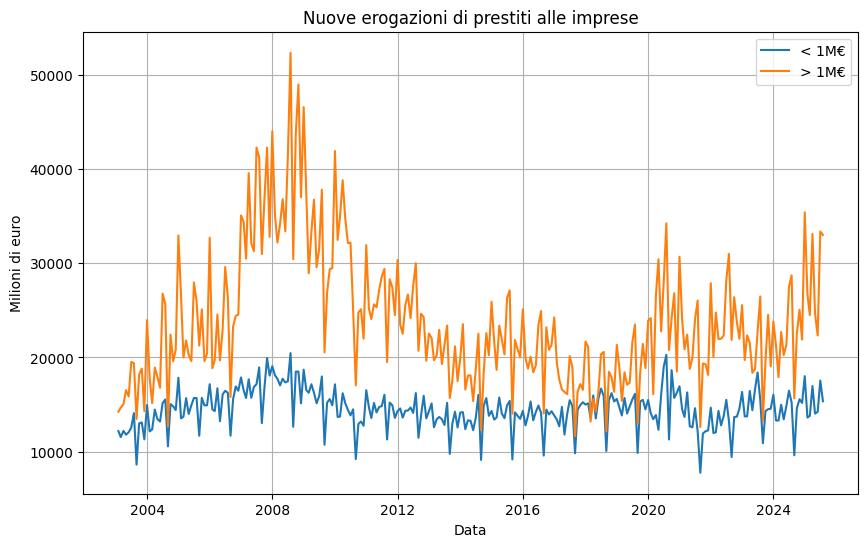

In [3]:
import matplotlib.pyplot as plt

prestiti = tab[[
    "Prestiti - Tot. - Tot",
    "Prestiti - Tot. - < 1M€",
    "Prestiti - Tot. - > 1M€"
]]

plt.figure(figsize=(10,6))
# plt.plot(prestiti.index, prestiti["Prestiti - Tot. - Tot"], label="Totale")
plt.plot(prestiti.index, prestiti["Prestiti - Tot. - < 1M€"], label="< 1M€")
plt.plot(prestiti.index, prestiti["Prestiti - Tot. - > 1M€"], label="> 1M€")

plt.title("Nuove erogazioni di prestiti alle imprese")
plt.xlabel("Data")
plt.ylabel("Milioni di euro")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Calcolo di prestiti_smooth come media mobile a 6 mesi
prestiti_smooth = (
    tab[[
        "Prestiti - Tot. - Tot",
        "Prestiti - Tot. - < 1M€",
        "Prestiti - Tot. - > 1M€"
    ]]
    .rolling(window=6, min_periods=1, center=True)
    .mean()
)

prestiti_smooth.head(12)


SERIE_DECOD,Prestiti - Tot. - Tot,Prestiti - Tot. - < 1M€,Prestiti - Tot. - > 1M€
DATA_OSS,,,
2025-07-31,45278.066667,15706.933333,29571.133333
2025-06-30,43632.000000,15289.550000,28342.450000
2025-05-31,44921.060000,15623.400000,29297.660000
2025-04-30,43813.016667,15316.666667,28496.350000
2025-03-31,42481.550000,15028.083333,27453.466667
2025-02-28,42898.333333,15106.433333,27791.900000
2025-01-31,42983.850000,15264.083333,27719.766667
2024-12-31,43304.833333,15517.666667,27787.166667
2024-11-30,41155.200000,15125.416667,26029.783333


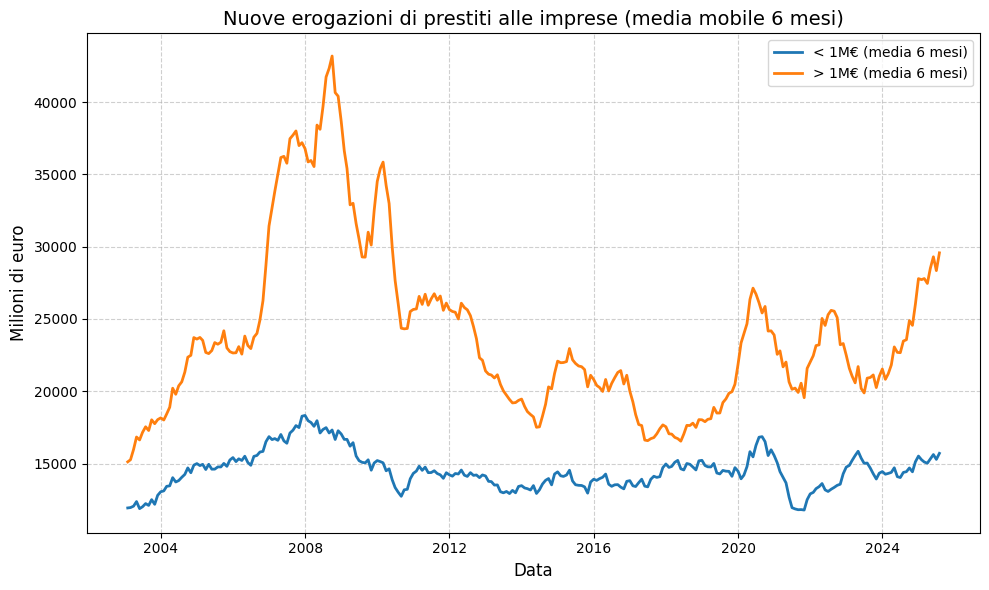

In [5]:
plt.figure(figsize=(10,6))
plt.plot(prestiti_smooth.index, prestiti_smooth["Prestiti - Tot. - < 1M€"], 
         label="< 1M€ (media 6 mesi)", linewidth=2, color="tab:blue")
plt.plot(prestiti_smooth.index, prestiti_smooth["Prestiti - Tot. - > 1M€"], 
         label="> 1M€ (media 6 mesi)", linewidth=2, color="tab:orange")

plt.title("Nuove erogazioni di prestiti alle imprese (media mobile 6 mesi)", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Milioni di euro", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



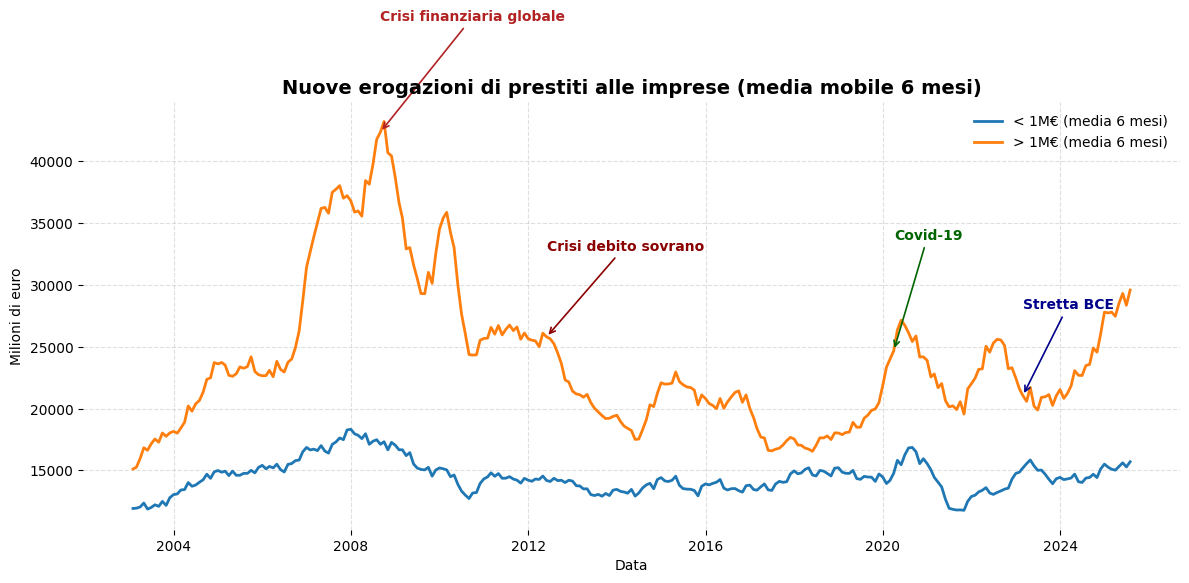

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

col_big = "Prestiti - Tot. - > 1M€"
col_small = "Prestiti - Tot. - < 1M€"

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(prestiti_smooth.index, prestiti_smooth[col_small], label="< 1M€ (media 6 mesi)", linewidth=2)
ax.plot(prestiti_smooth.index, prestiti_smooth[col_big],   label="> 1M€ (media 6 mesi)", linewidth=2)

ax.set_title("Nuove erogazioni di prestiti alle imprese (media mobile 6 mesi)", fontsize=14, weight="bold")
ax.set_xlabel("Data"); ax.set_ylabel("Milioni di euro")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(frameon=False)

def annotate_event(date_str, text, color="#333", y_offset=8000):
    """Aggancia l’annotazione al timestamp dell’indice più vicino a date_str."""
    d = pd.to_datetime(date_str)
    # trova l’indice più vicino
    idx = prestiti_smooth.index.get_indexer([d], method="nearest")[0]
    x = prestiti_smooth.index[idx]
    y = prestiti_smooth.loc[x, col_big]
    if np.isnan(y):
        # fallback: se NaN su quella serie, usa l'altra
        y = prestiti_smooth.loc[x, col_small]
    ax.annotate(
        text, xy=(x, y), xytext=(x, y + y_offset),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.2),
        fontsize=10, color=color, weight="bold"
    )

# Annotazioni (usa date approssimate: la funzione sceglie il punto più vicino)
annotate_event("2008-09-01", "Crisi finanziaria globale", "#b22222", y_offset=9000)
annotate_event("2012-06-01", "Crisi debito sovrano",     "#8b0000", y_offset=7000)
annotate_event("2020-04-01", "Covid-19",                 "#006400", y_offset=9000)
annotate_event("2023-03-01", "Stretta BCE",              "#00008b", y_offset=7000)

# ax.axvspan(pd.Timestamp("2008-09-01"), pd.Timestamp("2009-06-01"), color="#b22222", alpha=0.08)

# Spine pulite
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt

col_big = "Prestiti - Tot. - > 1M€"
col_small = "Prestiti - Tot. - < 1M€"
base_date = "2020-01-01"

# Copia del dataframe
prestiti_base100 = prestiti.copy()

# Normalizzazione in base 100 dal primo valore disponibile ≥ 2020-01
for col in [col_big, col_small]:
    base_value = prestiti_base100.loc[prestiti_base100.index >= base_date, col].iloc[0]
    prestiti_base100[col] = prestiti_base100[col] / base_value * 100

# Applica smoothing con media mobile 6 mesi centrata
prestiti_smooth100 = prestiti_base100.rolling(window=6, center=True).mean()

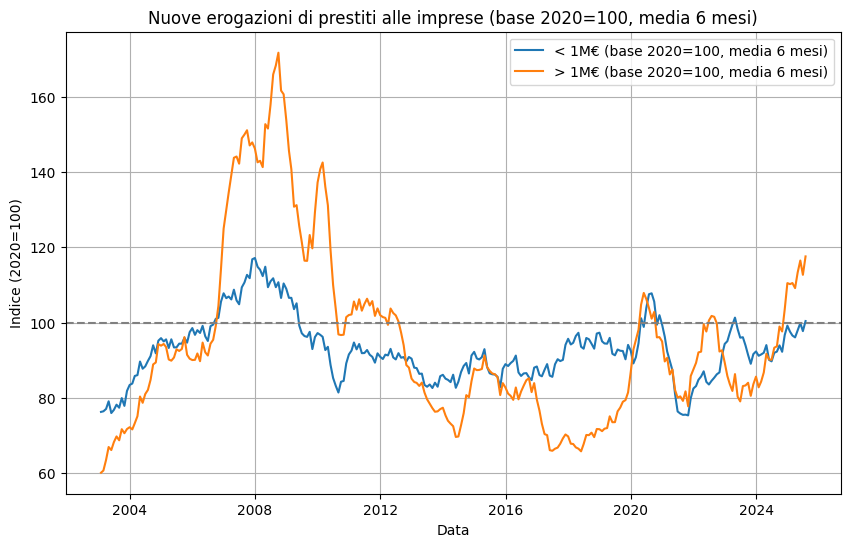

In [8]:
base_year = 2020
prestiti_base = prestiti_smooth.loc[str(base_year)]

# calcolo della media 2020 per ogni colonna
base_values = prestiti_base.mean()

prestiti_index = prestiti_smooth / base_values * 100

plt.figure(figsize=(10,6))
plt.plot(prestiti_index.index, prestiti_index[col_small], label="< 1M€ (base 2020=100, media 6 mesi)")
plt.plot(prestiti_index.index, prestiti_index[col_big], label="> 1M€ (base 2020=100, media 6 mesi)")

plt.axhline(100, color="gray", linestyle="--")
plt.title("Nuove erogazioni di prestiti alle imprese (base 2020=100, media 6 mesi)")
plt.xlabel("Data")
plt.ylabel("Indice (2020=100)")
plt.legend()
plt.grid(True)
plt.show()

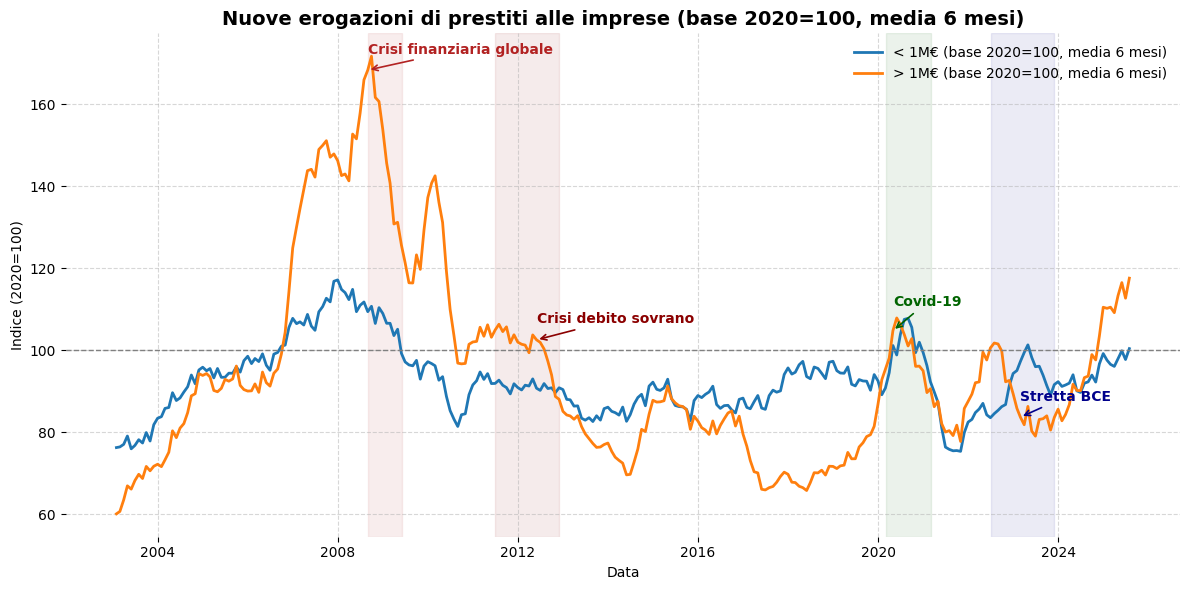

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

col_small = "Prestiti - Tot. - < 1M€"
col_big   = "Prestiti - Tot. - > 1M€"

# --- funzione annotazione robusta (aggancia al punto più vicino) ---
def annotate_event(ax, df, date_str, text, series_col, color="#333", y_offset=6):
    d = pd.to_datetime(date_str)
    idx = df.index.get_indexer([d], method="nearest")[0]
    x  = df.index[idx]
    y  = df.loc[x, series_col]
    ax.annotate(text, xy=(x, y), xytext=(x, y + y_offset),
                arrowprops=dict(arrowstyle="->", color=color, lw=1.2),
                fontsize=10, color=color, weight="bold")

# --- plot base 2020=100 con media 6 mesi (già in prestiti_index) ---
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(prestiti_index.index, prestiti_index[col_small],
        label="< 1M€ (base 2020=100, media 6 mesi)", lw=2, color="#1f77b4")
ax.plot(prestiti_index.index, prestiti_index[col_big],
        label="> 1M€ (base 2020=100, media 6 mesi)", lw=2, color="#ff7f0e")

ax.set_title("Nuove erogazioni di prestiti alle imprese (base 2020=100, media 6 mesi)",
             fontsize=14, weight="bold")
ax.set_xlabel("Data"); ax.set_ylabel("Indice (2020=100)")
ax.axhline(100, color="gray", ls="--", lw=1)
ax.grid(True, ls="--", alpha=0.5)

# --- bande verticali per i periodi-chiave ---
bands = [
    ("2008-09-01", "2009-06-01", "#b22222", 0.08, "Crisi 2008-09"),
    ("2011-07-01", "2012-12-01", "#8b0000", 0.08, "Crisi debito sovrano"),
    ("2020-03-01", "2021-03-01", "#006400", 0.08, "Covid-19"),
    ("2022-07-01", "2023-12-01", "#00008b", 0.08, "Stretta BCE"),
]
for start, end, color, alpha, _ in bands:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=alpha)

# --- frecce/etichette (uso la serie >1M€ per ancorare le frecce) ---
annotate_event(ax, prestiti_index, "2008-09-01", "Crisi finanziaria globale",
               col_big, color="#b22222", y_offset=4)
annotate_event(ax, prestiti_index, "2012-06-01", "Crisi debito sovrano",
               col_big, color="#8b0000", y_offset=4)
annotate_event(ax, prestiti_index, "2020-05-01", "Covid-19",
               col_big, color="#006400", y_offset=6)
annotate_event(ax, prestiti_index, "2023-03-01", "Stretta BCE",
               col_big, color="#00008b", y_offset=4)

# legenda pulita e stile minimal
ax.legend(frameon=False, loc="upper right")
for s in ax.spines.values():
    s.set_visible(False)

plt.tight_layout()
plt.show()


Ottimo, ora il **YoY (Year-over-Year)** è molto più leggibile 👍.
Ti faccio una lettura dei trend principali mettendoli in relazione con gli eventi storici ed economici che spiegano le dinamiche delle nuove erogazioni di prestiti alle imprese:

---

### 🔹 2003-2007: espansione pre-crisi

* Le nuove erogazioni, soprattutto **>1M€**, crescono con tassi YoY anche del +20/40%.
* **Cause**: fase di crescita economica mondiale, credito abbondante, tassi BCE relativamente bassi, forte leva finanziaria nelle imprese.
* È il periodo in cui il credito bancario si espande prima della crisi subprime.

---

### 🔹 2008-2012: crisi finanziaria e crisi del debito sovrano

* **Crollo del 2008-09**: YoY crolla a –40/–50% → riflette il credit crunch dovuto al fallimento Lehman e al congelamento dei mercati interbancari.
* **Breve rimbalzo 2010** (stimoli fiscali e monetari post-crisi).
* **Nuovo calo 2011-2012**: crisi del debito sovrano europeo → banche italiane riducono fortemente l’offerta di credito, soprattutto per i prestiti >1M€ (imprese medio-grandi).

---

### 🔹 2013-2016: stagnazione e deleveraging

* YoY mediamente negativo o intorno allo zero → segnale di deleveraging: le imprese riducono l’indebitamento, le banche razionano il credito.
* **Cause**: recessione italiana, stretta regolamentare (Basilea 3), crescita bassa, aumento sofferenze bancarie.
* Prestiti <1M€ (PMI e microimprese) più stabili ma comunque su livelli bassi.

---

### 🔹 2017-2019: ripresa moderata

* Tassi YoY tornano positivi, ma senza picchi.
* **Cause**: politica monetaria ultra-espansiva BCE (QE, tassi negativi), spread BTP-Bund sotto controllo, fiducia in miglioramento.
* La ripresa resta fragile: crescita limitata, domanda di credito non esplosiva.

---

### 🔹 2020-2021: shock pandemico

* **Crollo immediato** marzo 2020 (lockdown, incertezza).
* **Boom successivo**: misure straordinarie (garanzie pubbliche MCC, moratorie, liquidità BCE) → picco YoY oltre +60% sia <1M€ che >1M€.
* Questa fase segna il massimo delle nuove erogazioni negli ultimi 20 anni.

---

### 🔹 2022-2023: inflazione e stretta BCE

* YoY torna fortemente negativo (–20/–30%).
* **Cause**: aumento tassi BCE dal luglio 2022, inflazione elevata, costo del credito schizzato al 6-7% medio.
* Colpisce soprattutto prestiti >1M€, cioè le imprese più esposte a fabbisogni di capitale per investimenti.

---

### 🔹 2024-2025: stabilizzazione fragile

* YoY rimane volatile ma meno estremo.
* **Cause**: politica monetaria ancora restrittiva, domanda debole, incertezza geopolitica.
* Si intravede una differenza strutturale: i <1M€ tendono a essere più resilienti, mentre i >1M€ mostrano maggiore ciclicità.

---

📌 **Sintesi:**

* I prestiti **>1M€** sono molto più sensibili al ciclo economico e agli shock finanziari → riflettono investimenti e grandi operazioni aziendali.
* I prestiti **<1M€** sono più legati al capitale circolante delle PMI → meno volatili, ma soffrono nelle fasi di stretta creditizia prolungata.
* I picchi YoY (positivi e negativi) coincidono con **crisi sistemiche o interventi pubblici** (2008, 2012, 2020, 2022).

---

Vuoi che ti preparo un **grafico annotato** (con frecce e label “Crisi 2008”, “QE BCE”, “Covid”, “Stretta 2022”) così diventa anche un ottimo materiale da presentazione?


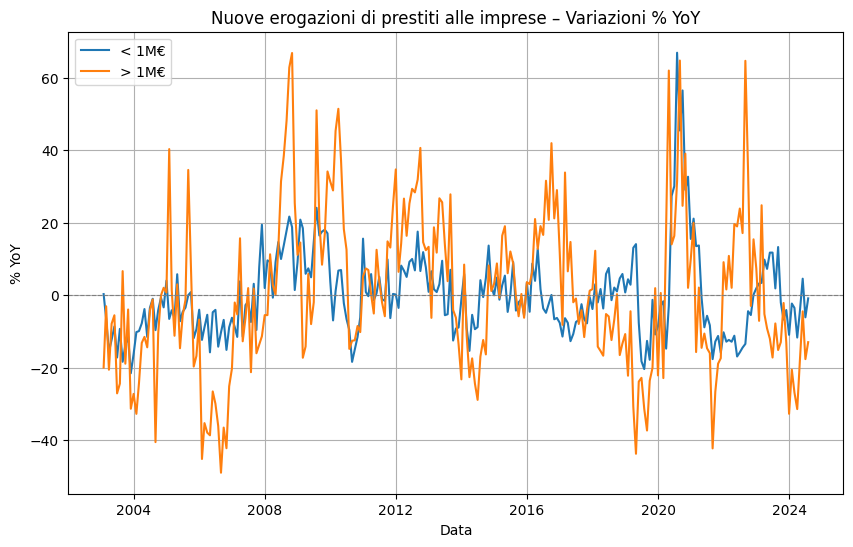

In [10]:
# Calcola YoY (variazione % rispetto a 12 mesi prima)
prestiti_yoy = prestiti.pct_change(periods=12) * 100

plt.figure(figsize=(10,6))
plt.plot(prestiti_yoy.index, prestiti_yoy["Prestiti - Tot. - < 1M€"], label="< 1M€")
plt.plot(prestiti_yoy.index, prestiti_yoy["Prestiti - Tot. - > 1M€"], label="> 1M€")

plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
plt.title("Nuove erogazioni di prestiti alle imprese – Variazioni % YoY")
plt.xlabel("Data")
plt.ylabel("% YoY")
plt.legend()
plt.grid(True)
plt.show()


<positron-console-cell-11>:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


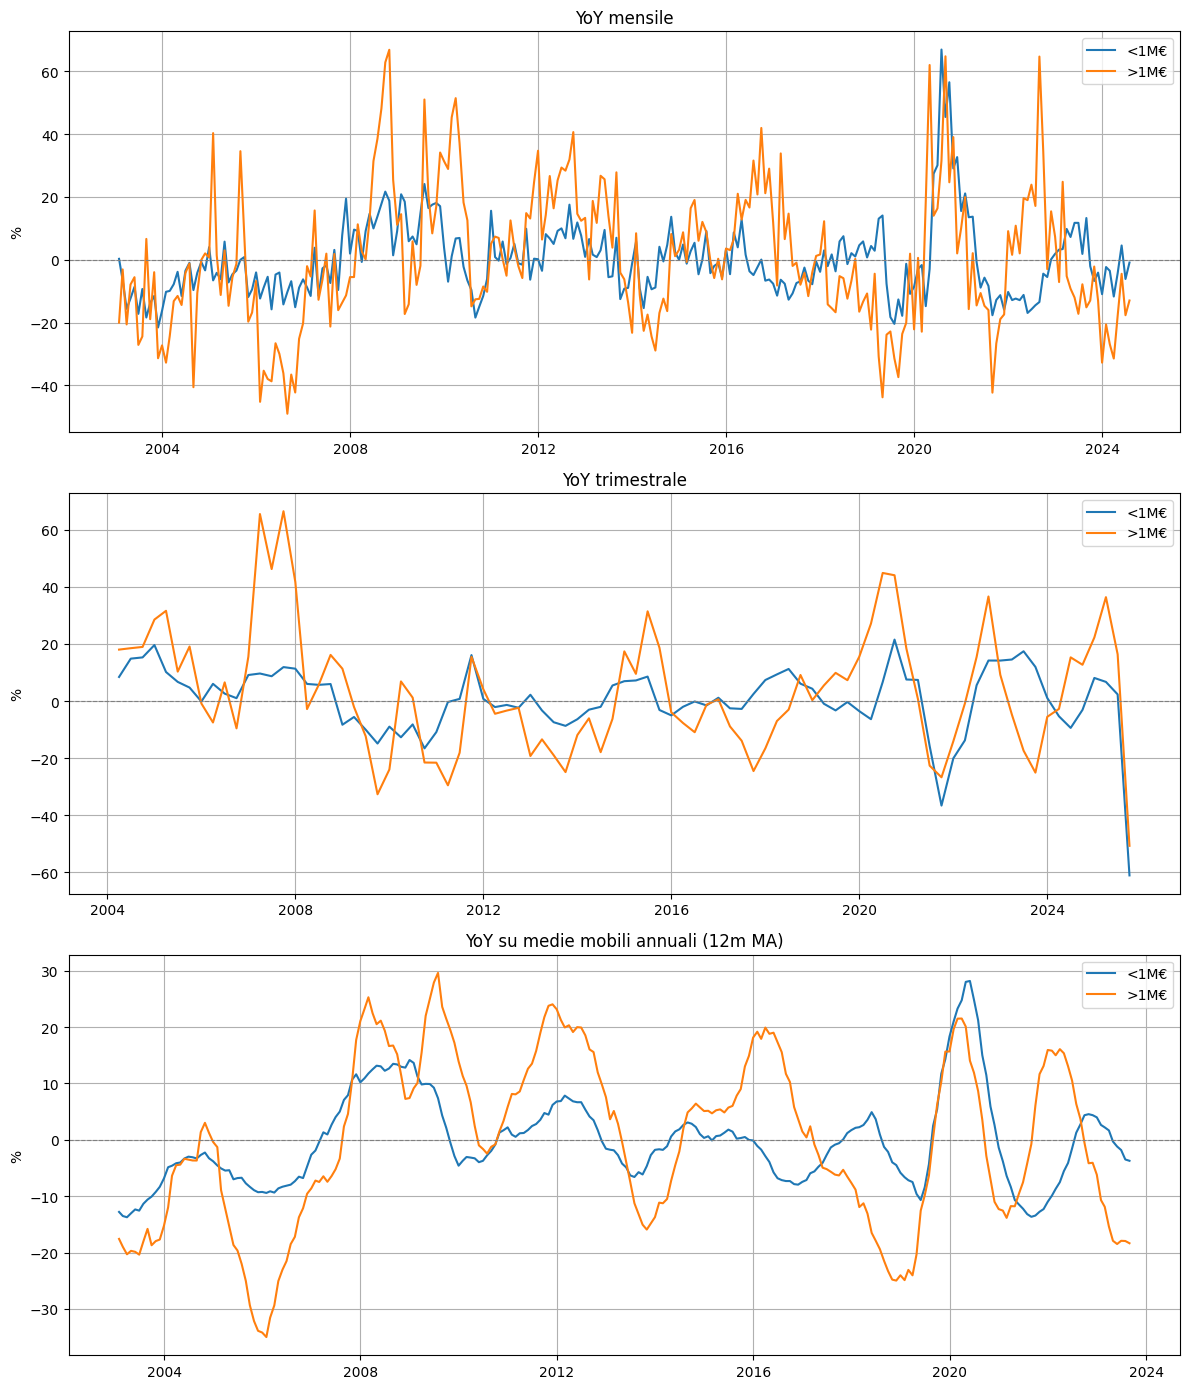

In [11]:
import matplotlib.pyplot as plt

# --- 1. YoY mensile ---
yoy_m = prestiti.pct_change(12) * 100

# --- 2. YoY trimestrale ---
prestiti_q = prestiti.resample("Q").sum()
yoy_q = prestiti_q.pct_change(4) * 100

# --- 3. YoY su media mobile annuale ---
prestiti_ma = prestiti.rolling(12).mean()
yoy_ma = prestiti_ma.pct_change(12) * 100

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharey=False)

# 1. Mensile
axes[0].plot(yoy_m.index, yoy_m["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[0].plot(yoy_m.index, yoy_m["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[0].axhline(0, color="gray", ls="--", lw=0.8)
axes[0].set_title("YoY mensile")
axes[0].set_ylabel("%")
axes[0].legend(); axes[0].grid(True)

# 2. Trimestrale
axes[1].plot(yoy_q.index, yoy_q["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[1].plot(yoy_q.index, yoy_q["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[1].axhline(0, color="gray", ls="--", lw=0.8)
axes[1].set_title("YoY trimestrale")
axes[1].set_ylabel("%")
axes[1].legend(); axes[1].grid(True)

# 3. Media mobile annuale
axes[2].plot(yoy_ma.index, yoy_ma["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[2].plot(yoy_ma.index, yoy_ma["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[2].axhline(0, color="gray", ls="--", lw=0.8)
axes[2].set_title("YoY su medie mobili annuali (12m MA)")
axes[2].set_ylabel("%")
axes[2].legend(); axes[2].grid(True)

plt.tight_layout()
plt.show()



<positron-console-cell-12>:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


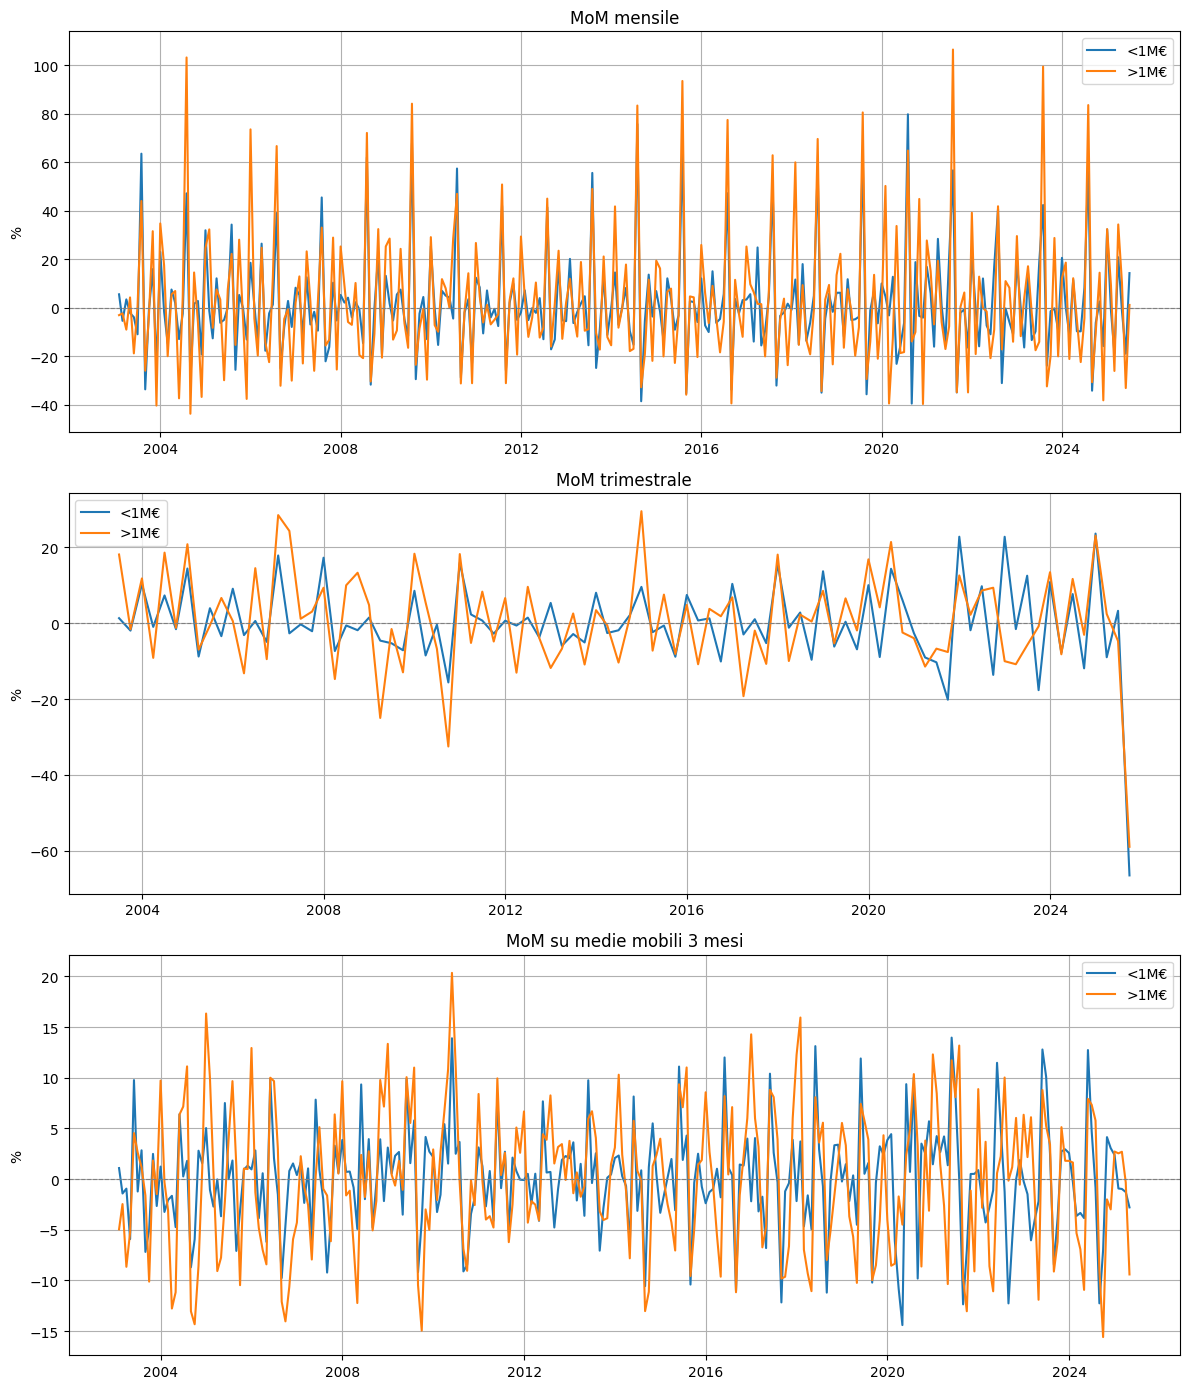

In [12]:
# --- 1. MoM mensile ---
mom_m = prestiti.pct_change(1) * 100

# --- 2. MoM trimestrale ---
prestiti_q = prestiti.resample("Q").sum()
mom_q = prestiti_q.pct_change(1) * 100

# --- 3. MoM su media mobile 3 mesi ---
prestiti_ma3 = prestiti.rolling(3).mean()
mom_ma3 = prestiti_ma3.pct_change(1) * 100

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharey=False)

# 1. Mensile
axes[0].plot(mom_m.index, mom_m["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[0].plot(mom_m.index, mom_m["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[0].axhline(0, color="gray", ls="--", lw=0.8)
axes[0].set_title("MoM mensile")
axes[0].set_ylabel("%")
axes[0].legend(); axes[0].grid(True)

# 2. Trimestrale
axes[1].plot(mom_q.index, mom_q["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[1].plot(mom_q.index, mom_q["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[1].axhline(0, color="gray", ls="--", lw=0.8)
axes[1].set_title("MoM trimestrale")
axes[1].set_ylabel("%")
axes[1].legend(); axes[1].grid(True)

# 3. Media mobile 3 mesi
axes[2].plot(mom_ma3.index, mom_ma3["Prestiti - Tot. - < 1M€"], label="<1M€")
axes[2].plot(mom_ma3.index, mom_ma3["Prestiti - Tot. - > 1M€"], label=">1M€")
axes[2].axhline(0, color="gray", ls="--", lw=0.8)
axes[2].set_title("MoM su medie mobili 3 mesi")
axes[2].set_ylabel("%")
axes[2].legend(); axes[2].grid(True)

plt.tight_layout()
plt.show()


In [13]:
df['SERIE'].unique()

array(['BAM_MIR.M.1300010.MIR5427.9.951.47.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5427.9.951.46.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5427.9.951.1000.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5414.9.951.47.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5414.9.951.46.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5414.9.951.1000.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5411.9.951.47.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5411.9.951.46.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5411.9.951.1000.SBI77.EUR.110.997',
       'BAM_MIR.M.1300010.MIR5411.5.951.1000.SBI77.EUR.110.997'], dtype=object)